In [2]:
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Intro

WebScrapper and DataFrame mounting of the data measured by different weather stations in Chile.

The weather stations with their corresponding location and `Station_ID` can be seen at: https://climatologia.meteochile.gob.cl/application/informacion/mapaDeEstaciones/

# Acquiring Data with WebScrapper

Function that retrieves the data in the html tables of https://climatologia.meteochile.gob.cl for a single **Weather station, month, year and variable**. 
The function returns a **DataFrame** with the correctly named columns and all the data *(or lack of)* in the link.

A stamp for the corresponding **year** and **month** is added for further mounting of the monthly **DataFrames**.

The function currently supports just 3 of all the measured variables. **[Temperature, Precipitation and Humidity]** 

## HTML Table extraction and DataFrame mounting for single Station, year, month and variable

Function receives a single year, month, variable and station, retrieves the table corresponding to those inputs and returns a clean DataFrame.

**The variables that can be received as input are:**

   1. var='temp' --- for **Temperature** data.
   1. var='pp' --- for **Precipitation** data.
   1. var='hh' --- for **Humidity** data.
   
All the other inputs are received as numeric *ints*.

**Months** are represented by *ints* from 1 to 12. `(Examples: January = 1, December = 12)`

In [3]:
 def df_by_year_month_var(year, month, var, station):
    
    var_link = {'temp': 'temperaturaMediaMensual', 'pp': 'aguaCaidaMensual', 'hh': 'humedadMensual'}
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
        
    link = 'https://climatologia.meteochile.gob.cl/application/mensuales/{}/{}/{}/{}'.format(var_link[var], str(station), str(year), str(month))
    
    html = requests.get(link).content

    items_list = pd.read_html(html)
    
    try:
    
        month_df = items_list[2]

        if var == 'temp':
            cols = ['Day', '12:00 UTC', '00:00 UTC', 'T_min', 'T_min hr',
                    'T_max', 'T_max hr', 'T_med Clim', 'T_med Avg', 'Data']

            final_cols = ['Year', 'Month', 'Day', '12:00 UTC', '00:00 UTC', 'T_min', 'T_min hr',
                          'T_max', 'T_max hr', 'T_med Clim', 'T_med Avg']

        elif var == 'pp':
            cols = ['Day', '12-18 UTC', '18-00 UTC', '00-06 UTC', '06-12 UTC', 'Daily Sum', 'Month aggregate']

            final_cols = ['Year', 'Month', 'Day', '00-06 UTC', '06-12 UTC', '12-18 UTC', '18-00 UTC',
                          'Daily Sum', 'Month aggregate']

        else:
            cols = ['Day', '12:00 UTC', '18:00 UTC', '00:00 UTC', 'Clim value', 'Avg value', 'Data']

            final_cols = ['Year', 'Month', 'Day', '12:00 UTC', '18:00 UTC', '00:00 UTC', 'Clim value', 'Avg value']

        month_df.columns = month_df.columns.droplevel()
        month_df.columns = cols

        month_df['Month'] = months[month-1]
        month_df['Year'] = str(year)

        month_df = month_df.iloc[:month_days[month-1]]

        month_df.reset_index(inplace = True, drop=True)

        month_df = month_df[final_cols]
        
        return month_df
        
    except:
        print('ERROR URL --- URL ERROR - [', var_link[var], station, year, month, ']')

## Create DataFrame of a single Station  and variable for a range of months and years

Function receives a list of years and months to retrieve the data available in the web and return a mounted DataFrame.

In [47]:
def yearly_temp_df(years, months, var, station):
        
    df = pd.DataFrame()
    
    for y in years:
        for m in months:
            
            month_df = df_by_year_month_var(y, m, var, station)
            
            df = df.append(month_df)
            
        print(y, ' - ', var, ' : DONE')
    
    return df

## Extracting yearly Data from 2000 to 2019 of a Station

The selected station is the one with `station_ID:` 	330019.

It is placed in an aerodrome in Chile's capital city, Santiago.

### Checks if there's a folder for saving the DataFrames as `.csv` and creates it if not

In [68]:
csvs_path = os.path.join(os.getcwd(), 'Created_csvs')

if os.path.exists(csvs_path) == False:
    os.makedirs(csvs_path)

### Defines `.csv` name based on inputs

In [69]:
def create_csv_name(years, months, var, station):

    if len(years) == 1:
        if len(months) == 1:
            csv_name = '{}_{}_{}_{}.csv'.format(station, months[0], years[0], var)
        else:
            csv_name = '{}_{}-{}_{}_{}.csv'.format(station, months[0], months[-1], years[0], var)
    else:
        if len(months) == 1:
            csv_name = '{}_{}_{}-{}_{}.csv'.format(station, months[0], years[0], years[-1], var)
        else:
            csv_name = '{}_{}-{}_{}-{}_{}.csv'.format(station, months[0], months[-1], years[0], years[-1], var)
    
    return csv_name

### Checks if `.csv`already exists and loads it or gets it from web

In [76]:
def check_load_csv(years, months, var, station):
    
    csv_name = create_csv_name(years, months, var, station)
    
    csv_path = os.path.join(csvs_path, csv_name)
    
    if os.path.exists(csv_path) == False:

        df = yearly_temp_df(years, months, var, station)
        
        df = df.replace('.', np.nan)
        
        if var == 'pp':
            df = df.replace('s/p', 0)
            
        num_cols = [col for col in df.columns if col not in ['Year', 'Month', 'Day', 'T_min hr', 'T_max hr']]
        
        df[num_cols] = df[num_cols].apply(pd.to_numeric)
            
        df.to_csv(csv_path)
    
    else:
        df = pd.read_csv(csv_path)
        
    return df

### Defining the lists for the relevant dates that want to be worked with

In [67]:
years = np.arange(2000,2020)
months = np.arange(1,13)

### Get Temperature data

In [71]:
temp = check_load_csv(years, months, 'temp', 330019)

2000  -  temp  : DONE
2001  -  temp  : DONE
2002  -  temp  : DONE
2003  -  temp  : DONE
2004  -  temp  : DONE
2005  -  temp  : DONE
2006  -  temp  : DONE
2007  -  temp  : DONE
2008  -  temp  : DONE
2009  -  temp  : DONE
2010  -  temp  : DONE
2011  -  temp  : DONE
2012  -  temp  : DONE
2013  -  temp  : DONE
2014  -  temp  : DONE
2015  -  temp  : DONE
2016  -  temp  : DONE
2017  -  temp  : DONE
2018  -  temp  : DONE
2019  -  temp  : DONE


### Get Precipitation data

In [80]:
precip = check_load_csv(years, months, 'pp', 330019)

2000  -  pp  : DONE
2001  -  pp  : DONE
2002  -  pp  : DONE
2003  -  pp  : DONE
2004  -  pp  : DONE
2005  -  pp  : DONE
2006  -  pp  : DONE
2007  -  pp  : DONE
2008  -  pp  : DONE
2009  -  pp  : DONE
2010  -  pp  : DONE
2011  -  pp  : DONE
2012  -  pp  : DONE
2013  -  pp  : DONE
2014  -  pp  : DONE
2015  -  pp  : DONE
2016  -  pp  : DONE
2017  -  pp  : DONE
2018  -  pp  : DONE
2019  -  pp  : DONE


### Get Humidity data

In [81]:
humid = check_load_csv(years, months, 'hh', 330019)

2000  -  hh  : DONE
2001  -  hh  : DONE
2002  -  hh  : DONE
2003  -  hh  : DONE
2004  -  hh  : DONE
2005  -  hh  : DONE
2006  -  hh  : DONE
2007  -  hh  : DONE
2008  -  hh  : DONE
2009  -  hh  : DONE
2010  -  hh  : DONE
2011  -  hh  : DONE
2012  -  hh  : DONE
2013  -  hh  : DONE
2014  -  hh  : DONE
2015  -  hh  : DONE
2016  -  hh  : DONE
2017  -  hh  : DONE
2018  -  hh  : DONE
2019  -  hh  : DONE


# Some Example plots to visualize the acquired data

## Anual plots by variable

Function to generate a plot of a single variable for a selected year from the already loaded DataFrames.

In [170]:
def yearly_plot(df, var, year):

    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    plt.style.use('grayscale')

    plt.figure(figsize=(20,7))
    
    date_cols = ['Year', 'Month', 'Day']
    
    if var == 'temp':
        cols = ['T_max', 'T_min', 'T_med Avg']
       
        df_plot = df[cols+date_cols].copy(deep=True)
        
        for col in cols:
            df_plot[col] = df_plot[col].rolling(window=7).mean()

        graph = df_plot[df_plot['Year'] == str(year_to_plot)].reset_index(drop=True)

        graph['T_max'].plot(color='red', label='T_max')
        graph['T_min'].plot(color='blue', label='T_min')
        graph['T_med Avg'].plot(color='green', label='T_avg')

        ax = plt.gca()
        ax.set_ylabel('Temperature [°C]')
        ax.legend()
        ax.set_title('Temperature values for the year {}'.format(year_to_plot))


        ax.axis([0,366,-10,40])
    
    elif var == 'pp':
        cols = ['Daily Sum', 'Month aggregate']
        
        df_plot = df[cols+date_cols].copy(deep=True)
        
        graph = df_plot[df_plot['Year'] == str(year_to_plot)].reset_index(drop=True)
        
        graph['Month aggregate'].plot(color='green', label='pp sum/month', kind='bar')
        graph['Daily Sum'].plot(color='blue', label='pp day', kind='bar')

        ax = plt.gca()
        ax.set_ylabel('Precipitation [mm]')
        ax.legend()
        ax.set_title('Precipitation values for the year {}'.format(year_to_plot))
        
        max_pp = graph['Month aggregate'].max()+10
        ax.axis([0,366,0,max_pp])
        
    elif var == 'hh':
        cols = ['Clim value']
        
        df_plot = df[cols+date_cols].copy(deep=True)
        
        graph = df_plot[df_plot['Year'] == str(year_to_plot)].reset_index(drop=True)
        
        graph['Clim value'].plot(color='blue', label='%HR', style='.')
        
        ax = plt.gca()
        
        ax.set_ylabel('Relative Humidity [%HR]')
        ax.legend()
        ax.set_title('Relative humidity values for the year {}'.format(year_to_plot))
        ax.axis([0,366,0,100])

    ax.set_xlabel('Time')  
    plt.grid()
    _ = plt.xticks([0,31,58,89,119,149,180,211,241,272,302,333], month_names)
    
    plt.rc('axes', titlesize=20)    
    plt.rc('axes', labelsize=20)    
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=15)    
    plt.rc('figure', titlesize=30)
    
    plt.xticks(rotation=70)

### Year to plot

Defining which year to plot

In [162]:
year_to_plot = 2000

#### Temperature

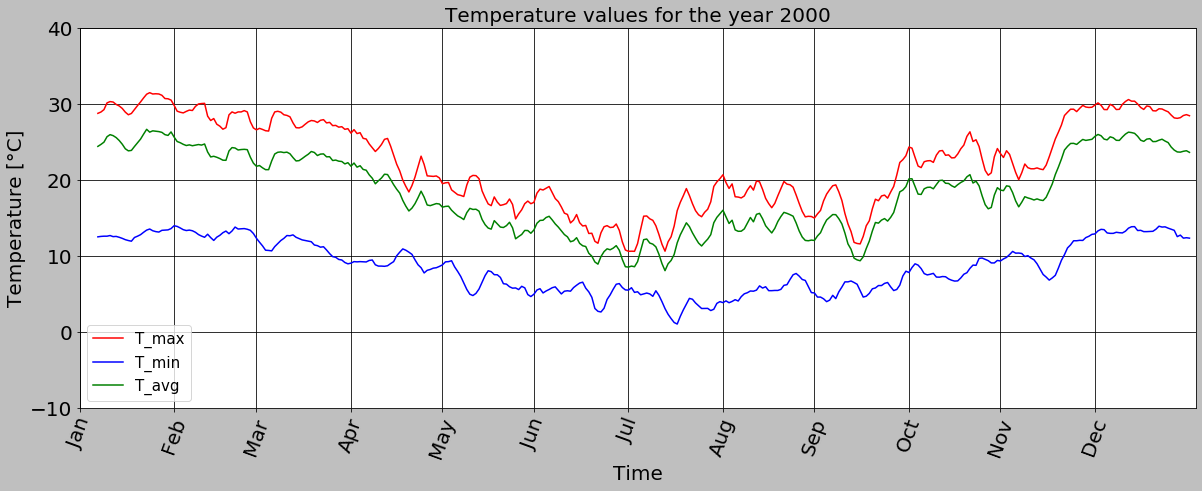

In [171]:
yearly_plot(temp, 'temp', year_to_plot)

#### Precipitation

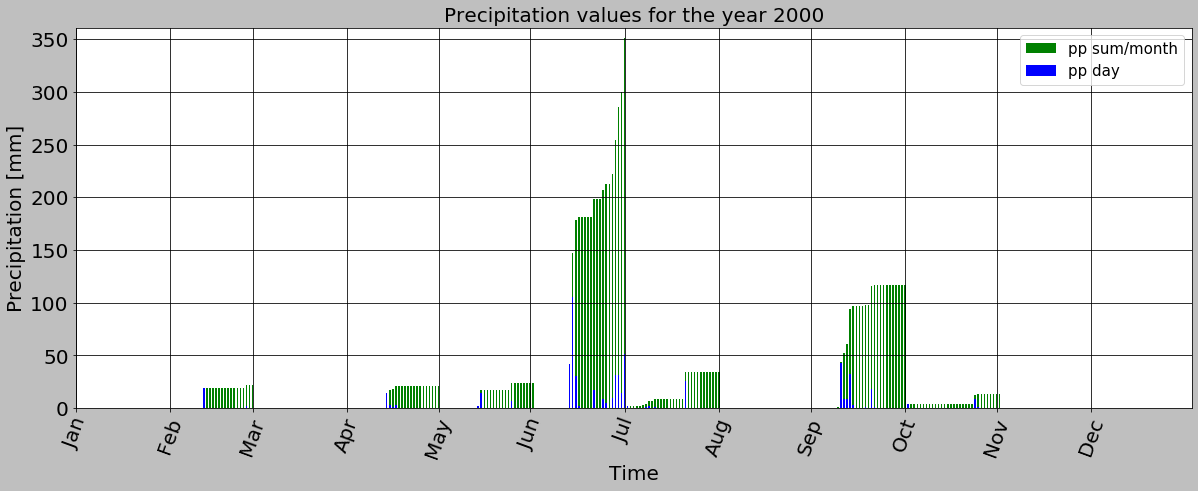

In [172]:
yearly_plot(precip, 'pp', year_to_plot)

#### Humidity

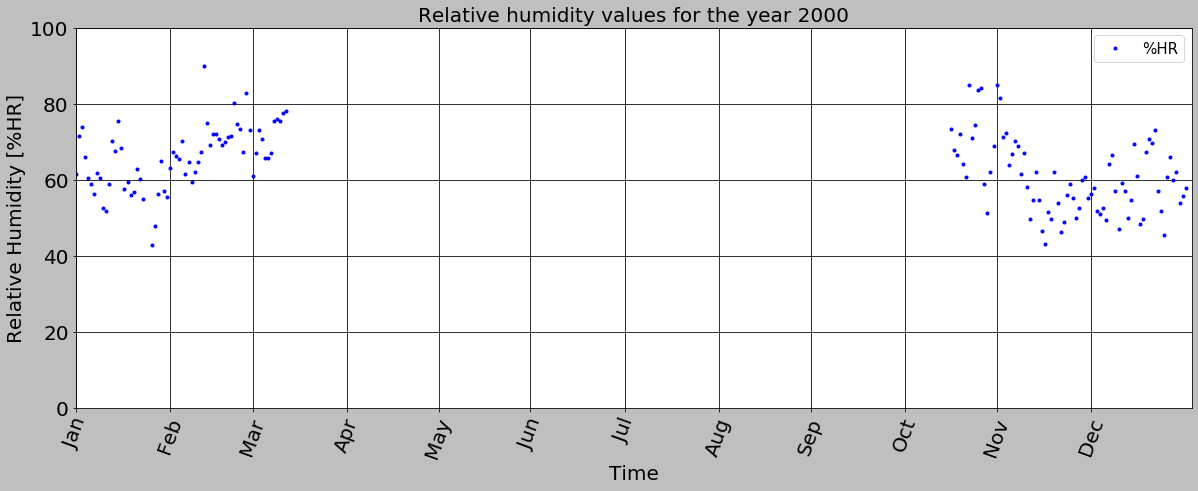

In [173]:
yearly_plot(humid, 'hh', year_to_plot)

## Historic plots by variable

This functions just plots all the data on the DataFrames corresponding to the introduced `var`

In [178]:
def historic_plot(df, var):

    plt.style.use('grayscale')

    plt.figure(figsize=(20,7))
    
    date_cols = ['Year', 'Month', 'Day']
    
    years_hist = df['Year'].unique()
    
    if var == 'temp':
        cols = ['T_max', 'T_min', 'T_med Avg']

        df_plot = df[cols+date_cols].copy(deep=True)
        
        for col in cols:
            df_plot[col] = df_plot[col].rolling(window=7).mean()
            
        graph = df_plot.reset_index(drop=True)

        graph['T_max'].plot(color='red', label='T_max')
        graph['T_min'].plot(color='blue', label='T_min')
        graph['T_med Avg'].plot(color='green', label='T_avg')
        
        ax = plt.gca()
        ax.set_ylabel('Temperature [°C]')
        ax.set_title('Historic Temperature values')


        ax.axis([0,df_plot.shape[0],-10,40])
        
    if var == 'pp':
        cols = ['Daily Sum', 'Month aggregate']
        
        df_plot = df[cols+date_cols].copy(deep=True)
        
        graph = df_plot.reset_index(drop=True)
        
        graph['Month aggregate'].plot(color='green', label='pp sum/month', kind='bar')
        graph['Daily Sum'].plot(color='blue', label='pp day', kind='bar')

        ax = plt.gca()
        ax.set_ylabel('Precipitation [mm]')
        ax.set_title('Historic Precipitation values')
        
        max_pp = graph['Month aggregate'].max()+10
        ax.axis([0,df_plot.shape[0],0,max_pp])
    
    if var == 'hh':
        cols = ['Clim value']
        
        df_plot = df[cols+date_cols].copy(deep=True)
        
        graph = df_plot.reset_index(drop=True)
        
        graph['Clim value'].plot(color='blue', label='%HR', style='.')
        
        ax = plt.gca()
        
        ax.set_ylabel('Relative Humidity [%HR]')
        ax.set_title('Historic Relative humidity values')
        ax.axis([0,df_plot.shape[0],0,100])
        

    ax.set_xlabel('Time')  
    plt.grid()
    ax.legend()
        
    
    _ = plt.xticks(np.arange(0,df.shape[0],365), years)
    
    plt.rc('axes', titlesize=20)    
    plt.rc('axes', labelsize=20)    
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=15)    
    plt.rc('figure', titlesize=30)
    
    plt.xticks(rotation=70)

### Temperature

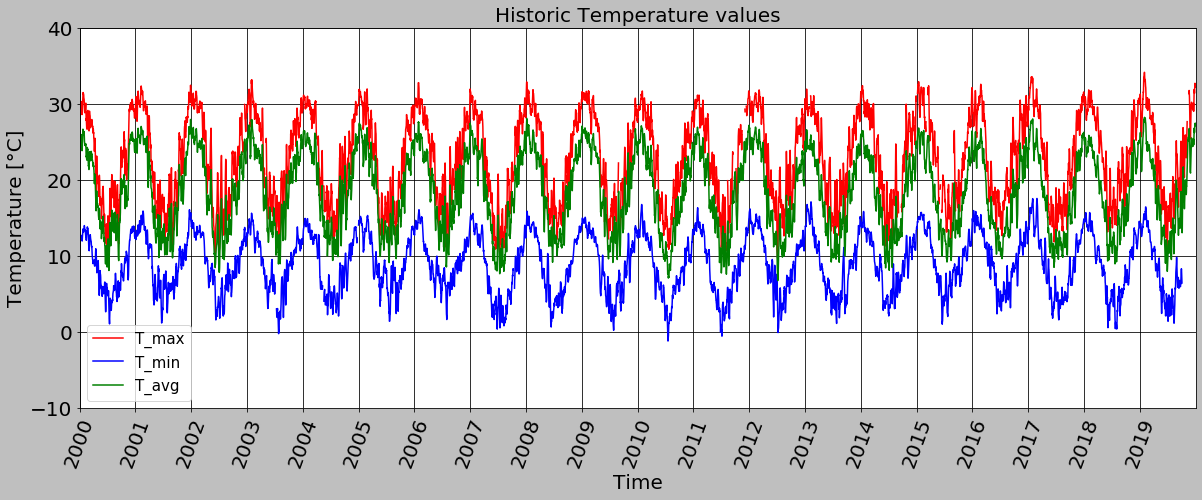

In [175]:
historic_plot(temp, 'temp')

### Precipitation

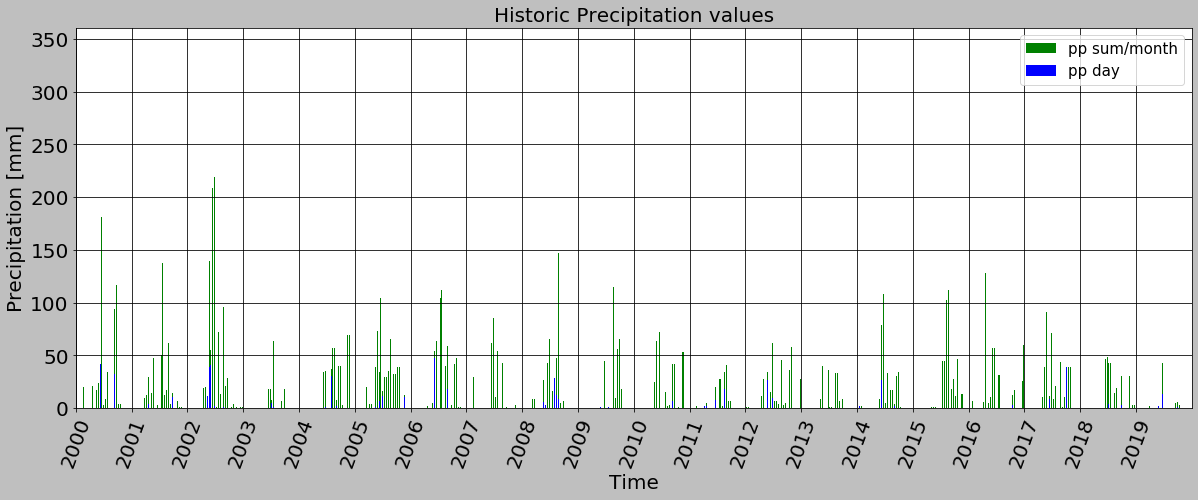

In [176]:
historic_plot(precip, 'pp')

### Humidity

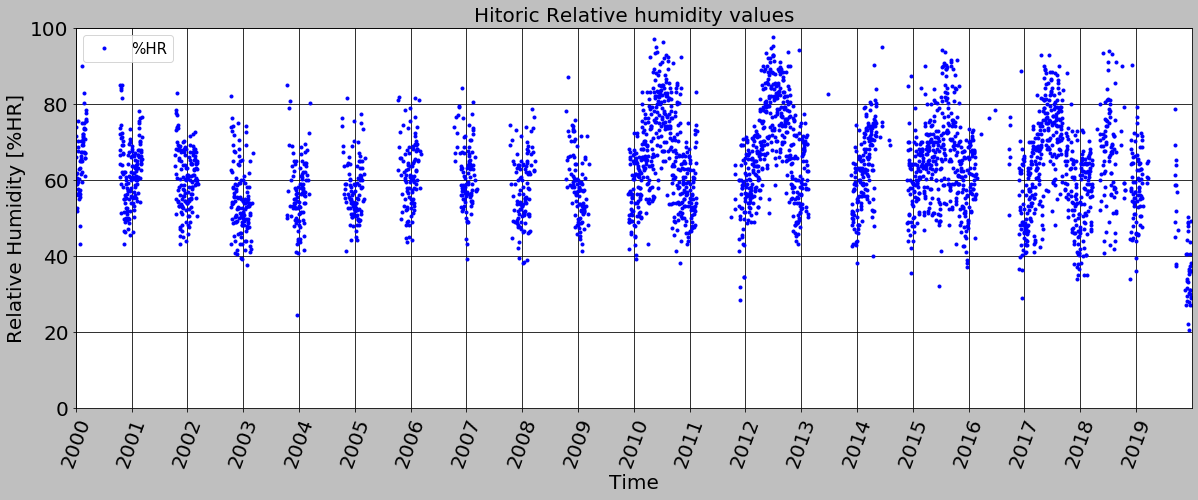

In [177]:
historic_plot(humid, 'hh')

## Comparative plot of historic variables

This function calculates the average values of two ranges of years, usually one for **old years** and another for **recent years** and returns three subplots with the superposition of the average values for the variables for each range; in order to visually show if there's any meaningful deviation.

In [250]:
def comparative_plot(temp, precip, humid, years1, years2):
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_dict = {'Jan': 0, 'Feb': 1, 'Mar': 2, 'Apr': 3,
               'May': 4, 'Jun': 5, 'Jul': 6, 'Aug': 7,
               'Sep': 8, 'Oct': 9, 'Nov': 10, 'Dec': 11}
    
    var_dict = {'temp': ['T_max', 'T_min', 'T_med Avg'], 'pp': ['Daily Sum', 'Month aggregate'], 'hh': ['Clim value']}
    
    measures = ['T_max', 'T_min', 'T_med Avg', 'Daily Sum', 'Month aggregate', 'Clim value']
    cols = ['Year', 'Month', 'Day'] + measures
        

    plt.style.use('grayscale')
    fig, ((ax1,ax2,ax3)) = plt.subplots(3, 1, sharex=True, figsize=(30,14))
    
    df = pd.DataFrame(columns=cols)
    
    df[var_dict['temp']] = temp[var_dict['temp']]
    df[var_dict['pp']] = precip[var_dict['pp']]
    df[var_dict['hh']] = humid[var_dict['hh']]
    df[['Year', 'Month', 'Day']] = temp[['Year', 'Month', 'Day']]
    
    df_plot = df[cols].reset_index(drop=True)
    
    years1 = [str(y) for y in years1]
    years2 = [str(y) for y in years2]
    
    
    df_plot_old = df_plot.loc[df_plot['Year'].isin(years1)].copy(deep=True)
    df_plot_new = df_plot.loc[df_plot['Year'].isin(years2)].copy(deep=True)
    
    df_plot_old[var_dict['temp']] = df_plot_old[var_dict['temp']].rolling(window=3).mean()
    df_plot_new[var_dict['temp']] = df_plot_new[var_dict['temp']].rolling(window=3).mean()        
    
    df_plot_old['Nmonth'] = df_plot_old['Month'].map(month_dict)
    df_plot_new['Nmonth'] = df_plot_new['Month'].map(month_dict)
        
    df_plot_old = (df_plot_old.groupby(['Nmonth', 'Day'])[measures]
            .mean()
            .reset_index()
            .sort_values(['Nmonth', 'Day']))
    
    df_plot_new = (df_plot_new.groupby(['Nmonth', 'Day'])[measures]
            .mean()
            .reset_index()
            .sort_values(['Nmonth', 'Day']))

    temp_old = df_plot_old[var_dict['temp']]
    temp_new = df_plot_new[var_dict['temp']]
    
    x_sh = [[-10,40], [0,df_plot_old['Month aggregate'].max()+10], [0,100]]
    
    temp_old['T_max'].plot(color='maroon', label='Max old', alpha=0.8, linewidth=7, ax=ax1)
    temp_old['T_min'].plot(color='midnightblue', label='Min old', alpha=0.8, linewidth=7, ax=ax1)
    temp_old['T_med Avg'].plot(color='darkolivegreen', label='Med old', alpha=0.8, linewidth=7, ax=ax1)
            
    temp_new['T_max'].plot(color='red', label='Max recent', linewidth=5, ax=ax1)
    temp_new['T_min'].plot(color='blue', label='Min recent', linewidth=5, ax=ax1)
    temp_new['T_med Avg'].plot(color='green', label='Med recent', linewidth=5, ax=ax1)
        
    ax1.fill_between(temp_new.index, temp_new['T_max'], temp_old['T_max'], facecolor='red', alpha=0.4)
    ax1.fill_between(temp_new.index, temp_new['T_min'], temp_old['T_min'], facecolor='blue', alpha=0.4)
    ax1.fill_between(temp_new.index, temp_new['T_med Avg'], temp_old['T_med Avg'], facecolor='green', alpha=0.4)
        
    ax1.axis([0,365,x_sh[0][0],x_sh[0][1]])
    ax1.set_ylabel('Temperature [°C]')
    
     
    df_plot_old['Month aggregate'].plot(color='darkolivegreen', label='pp sum/month old', kind='bar', alpha=0.65, ax=ax2)
    df_plot_new['Month aggregate'].plot(color='green', label='pp sum/month recent', kind='bar', alpha=0.85, ax=ax2)
    
    df_plot_old['Daily Sum'].plot(color='midnightblue', label='pp day old', kind='bar', ax=ax2)
    df_plot_new['Daily Sum'].plot(color='blue', label='pp day recent', kind='bar', ax=ax2)
    

    ax2.axis([0,365,x_sh[1][0],x_sh[1][1]])
    ax2.set_ylabel('Precipitation [mm]')
    
    df_plot_old['Clim value'].plot(color='firebrick', label='%HR old', style='.', markersize=9, ax=ax3)
    df_plot_new['Clim value'].plot(color='blue', label='%HR recent', style='.', markersize=9, ax=ax3)

    ax3.axis([0,365,x_sh[2][0],x_sh[2][1]])
    ax3.set_ylabel('Relative Humidity [%]')
        
    ax3.set_xlabel('Time')
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax1.grid()
    ax2.grid()
    ax3.grid()
    
    name = {'temp': 'Temperature', 'pp': 'Precipitation', 'h': 'Relative Humidity'}
    
    ax1.set_title('Measures comparison for station in Chile between {}-{} and {}-{}'
                 .format(years1[0], years1[-1], years2[0], years2[-1]))
            
    _ = plt.xticks([0,31,58,89,119,149,180,211,241,272,302,333], month_names)
    
    plt.rc('axes', titlesize=35)    
    plt.rc('axes', labelsize=20)    
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=20)    
    plt.rc('figure', titlesize=30)
    
    plt.xticks(rotation=70)
    plt.tight_layout()
    
    #plt.savefig('Fig_name')
    
    plt.show()

### Defining range of years to compare

Defining the range of years that want to be compared in the plot.

In [253]:
years1 = np.arange(2000,2015)
years2 = np.arange(2015,2020)

### Comparative plot

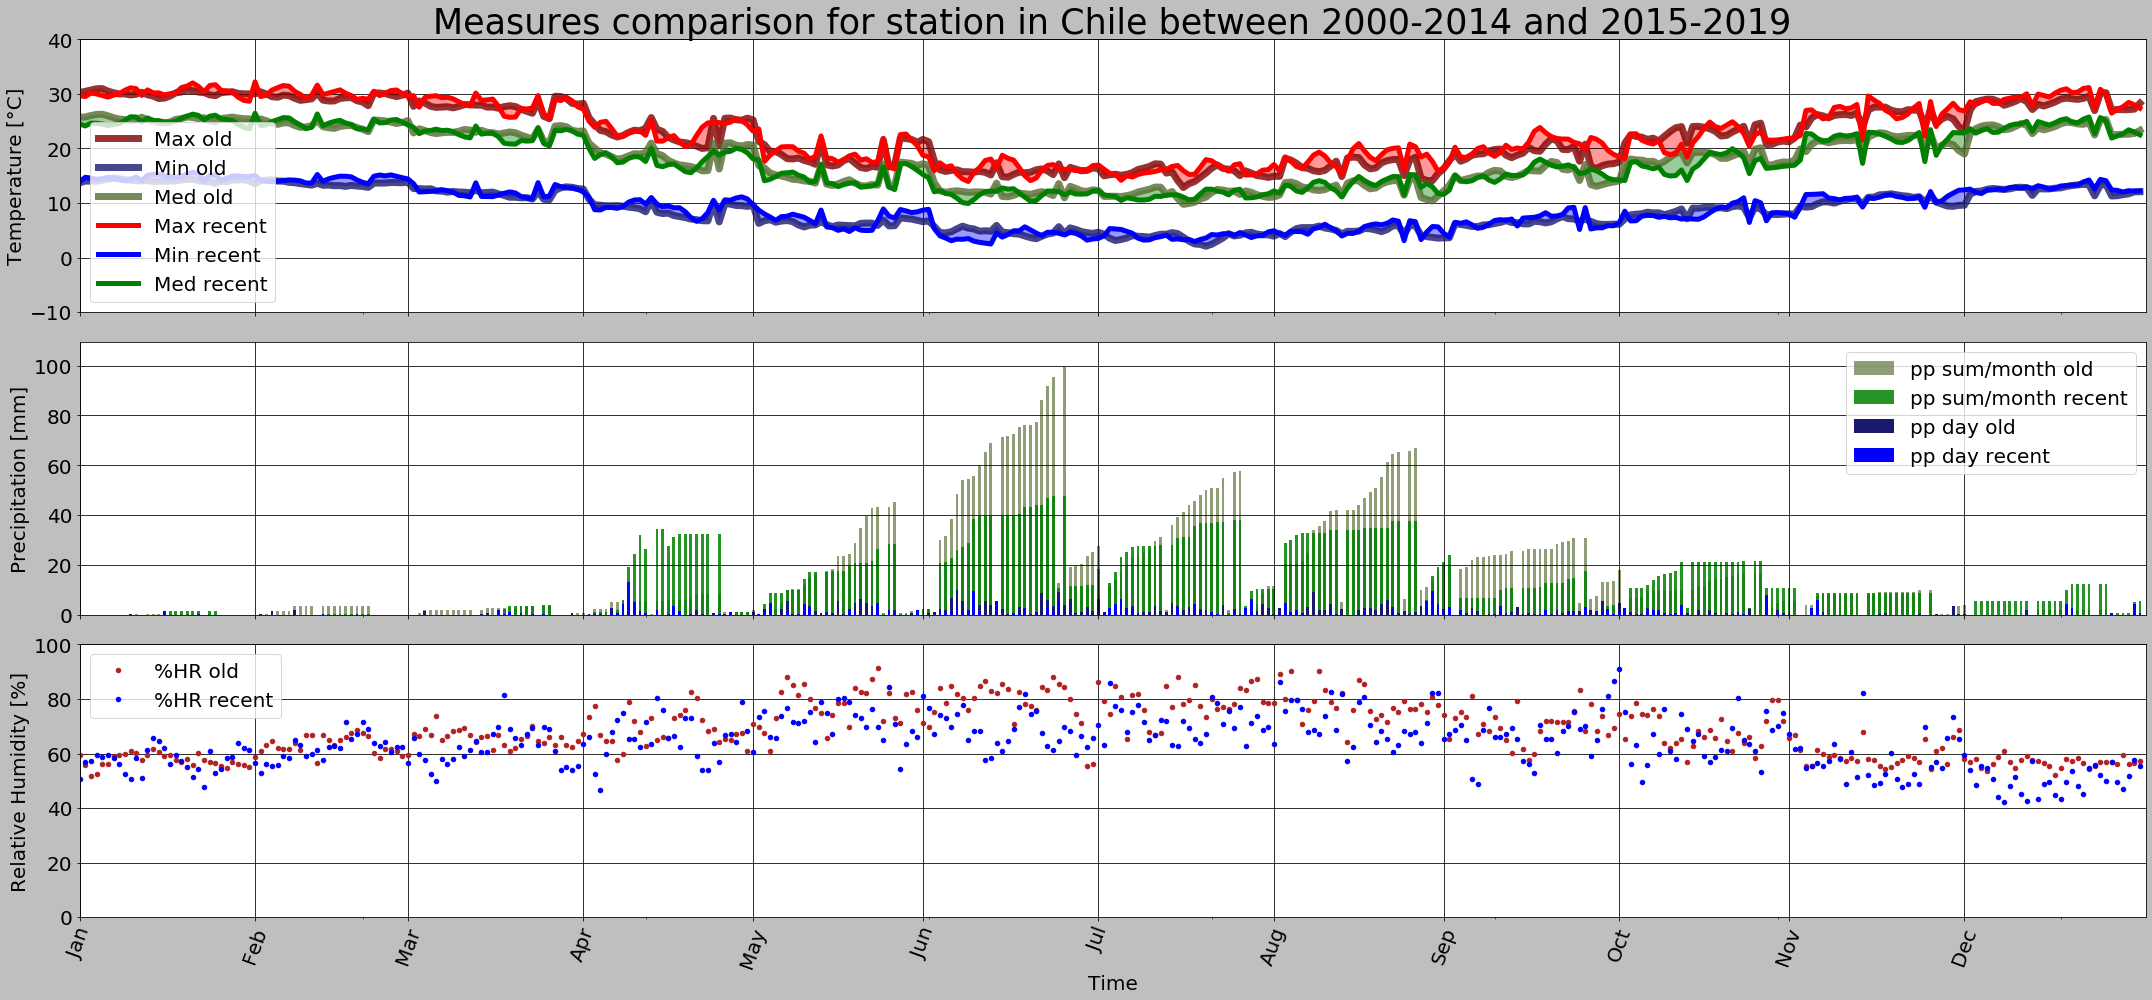

In [254]:
comparative_plot(temp, precip, humid, years1, years2)